## 1. Business Understanding

### 1.1 Overview

>Online shopping refers to a delivery and pick-up service. This particular service  is offered by companies through a website and mobile app. The service allows customers to order items from participating retailers with the shopping being done by a personal shopper or company. 

>Covid-19 has changed the way the world operates. The ‘new normal’ has also seen dramatic increases in online shopping trends for apparent reasons. Contactless transactions are safer, and lockdowns have given people no choice but to use online platforms to purchase goods. As you know, however, don’t last forever. Still, once a customer has experienced the convenience and safety of an initially obligated online shopping experience, they are very likely to use it again even when they don’t have to.

>Some of the advantages of online shopping include; there are a variety of products, it's covenient, there are a lot of online discounts, there is buyer/shopping secrecy, the customers can avoid crowds, you can find unique/rare products and there is detailed information about the products that you are buying.

>To effect some of these advantages of online shopping a recommendation system or recommendation engine can be used for information filtering where it tries to predict the preferences of a user and provide suggestions based on these preferences. 


### 1.2 Business Objectives

>1. To particularly provide product recommendations.

>2. To look for unique ways to personalize marketing to customer base.

>3. To determine the month with the highest sales so as to plan the optimal time to give discounts


### 1.3 Determining The Project Goals

### 1.4 Determining the project success criteria 

## 2. Data Understanding

### 2.1 Collecting Data

In [39]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [62]:
#Loading Data and previewing the first five rows
df = pd.read_csv('data.csv',encoding= 'unicode_escape')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 2.2 Describing the data

In [124]:
#Data Description
Description = pd.read_csv('data_description.csv',header=0,squeeze=True,dtype=str,keep_default_na=False,encoding='unicode_escape')

Description

,Column_Name,Description
0,InvoiceNo,"Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation."
1,StockCode,"Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product."
2,Description,Product (item) name. Nominal.
3,Quantity,The quantities of each product (item) per transaction. Numeric.
4,InvoiceDate,"Invoice Date and time. Numeric, the day and time when each transaction was generated."
5,UnitPrice,"Unit price. Numeric, Product price per unit in sterling."
6,CustomerID,"Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer."
7,Country,"Country name. Nominal, the name of the country where each customer resides."


In [64]:
#Looking at the shape of the data
df.shape

(541909, 8)

There are 541,909 rows and 8 columns in this data set

In [65]:
#looking at the information of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [66]:
# Summary statistics of the data set
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [67]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [68]:
df.duplicated().sum()

5268

## 3. Data Preparation

### 3.1 Creating a new data frame

### 3.1.1 Splitting the date 

In [69]:
# Spliting the date to years, months, day and time
df['Month'] = df['InvoiceDate'].apply(lambda x : x.split('/')[0]).astype(np.uint8)
df['Day'] = df['InvoiceDate'].apply(lambda x : x.split('/')[1]).astype(np.uint8)
df['Year'] = df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[0]).astype(np.uint16)
df['Time'] = df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[1])
df['Hour']= df['Time'].apply(lambda x : x.split(':')[0]).astype(np.uint8)
df['Min']= df['Time'].apply(lambda x : x.split(':')[1]).astype(np.uint8)
df['datetime'] = list(map(lambda x : datetime.date(x[0],x[1],x[2]),df[['Year','Month','Day']].values) )
df['Day_week'] = list(map(lambda x :x.weekday(),df['datetime'].values)) # datetime.date(2017,12,25)
df['Day_week'] = df['Day_week'].map({0:'1mon',1:'2tue',2:'3wed',3:'4thur',4:'5fri',5:'6sat',6:'0sun'})
df = df.sort_values('datetime')

df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,3wed
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed


### 3.1.2 Adding Total Cost Column

In [70]:
# Calculating the total cost per order
df['Total_Amount'] = df['Quantity']*df['UnitPrice']
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,3wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,6.75


In [72]:
#New data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     541909 non-null  object 
 1   StockCode     541909 non-null  object 
 2   Description   540455 non-null  object 
 3   Quantity      541909 non-null  int64  
 4   InvoiceDate   541909 non-null  object 
 5   UnitPrice     541909 non-null  float64
 6   CustomerID    406829 non-null  float64
 7   Country       541909 non-null  object 
 8   Month         541909 non-null  uint8  
 9   Day           541909 non-null  uint8  
 10  Year          541909 non-null  uint16 
 11  Time          541909 non-null  object 
 12  Hour          541909 non-null  uint8  
 13  Min           541909 non-null  uint8  
 14  datetime      541909 non-null  object 
 15  Day_week      541909 non-null  object 
 16  Total_Amount  541909 non-null  float64
dtypes: float64(3), int64(1), object(8), uint16(1), u

In [73]:
#New data shape
df.shape

(541909, 17)

In [74]:
#New data set first 5 rows
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,3wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,6.75


In [148]:
x = df['CustomerID'].value_counts()
x

17841.0    7812
14911.0    5898
14096.0    5128
12748.0    4459
14606.0    2759
15311.0    2478
14646.0    2085
13089.0    1853
13263.0    1667
14298.0    1640
15039.0    1483
14156.0    1415
18118.0    1268
14159.0    1183
14796.0    1156
15005.0    1152
16033.0    1143
14056.0    1110
17511.0    1076
14769.0    1066
13081.0    1061
14527.0    1010
14456.0     954
15719.0     932
16549.0     925
15555.0     913
16931.0     886
17811.0     849
14505.0     789
12415.0     778
17757.0     741
12921.0     741
17338.0     725
18283.0     721
17675.0     721
15159.0     720
16764.0     712
15547.0     695
17735.0     690
13137.0     688
16904.0     665
17920.0     665
15529.0     664
16729.0     664
16241.0     655
16923.0     650
12681.0     646
16360.0     645
15856.0     636
16713.0     627
13969.0     626
14502.0     615
13098.0     605
14194.0     604
14415.0     601
14088.0     590
13230.0     588
13694.0     584
17611.0     573
14667.0     570
15358.0     560
17602.0     556
17238.0 

<AxesSubplot:>

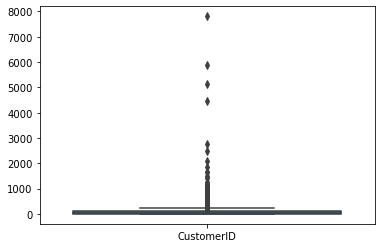

In [147]:
sns.boxplot(data=pd.DataFrame(x))

### 3.2 Cleaning the Data

#### 3.2.1 Duplicates

In [93]:
#Looking at the duplicates in the data set
df.duplicated().sum()/len(df)*100

0.0

In [95]:
#Dropping the duplicates from the data set
df = df.drop_duplicates()
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,3wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,3wed,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540815,581492,22358,KINGS CHOICE TEA CADDY,1,12/9/2011 10:03,5.79,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,5fri,5.79
540814,581492,22357,KINGS CHOICE BISCUIT TIN,2,12/9/2011 10:03,4.13,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,5fri,8.26
540813,581492,22356,CHARLOTTE BAG PINK POLKADOT,1,12/9/2011 10:03,1.63,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,5fri,1.63
540823,581492,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,1,12/9/2011 10:03,4.13,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,5fri,4.13


In [96]:
# Checking for duplicates after droping the duplicates
df.duplicated().sum()/len(df)*100

0.0

#### 3.2.2 Missing Values

Missing data in the E-commerce data set can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

In [97]:
df.isnull().sum()/len(df)* 100

InvoiceNo        0.000000
StockCode        0.000000
Description      0.270945
Quantity         0.000000
InvoiceDate      0.000000
UnitPrice        0.000000
CustomerID      25.163377
Country          0.000000
Month            0.000000
Day              0.000000
Year             0.000000
Time             0.000000
Hour             0.000000
Min              0.000000
datetime         0.000000
Day_week         0.000000
Total_Amount     0.000000
dtype: float64

In [111]:
df1 = df[df.isna().any(axis=1)]

df1.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
2102,536558,22802,FAUX FUR CHOCOLATE THROW,5,12/1/2010 14:48,19.95,NaN,United Kingdom,12,1,2010,14:48,14,48,2010-12-01,3wed,99.75
1969,536544,21758,VINTAGE SHELLS PRINT,1,12/1/2010 14:32,12.72,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,3wed,12.72
1970,536545,21134,NaN,1,12/1/2010 14:32,0.00,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,3wed,0.00
1971,536546,22145,NaN,1,12/1/2010 14:33,0.00,NaN,United Kingdom,12,1,2010,14:33,14,33,2010-12-01,3wed,0.00
1972,536547,37509,NaN,1,12/1/2010 14:33,0.00,NaN,United Kingdom,12,1,2010,14:33,14,33,2010-12-01,3wed,0.00
1968,536544,21742,LARGE ROUND WICKER PLATTER,1,12/1/2010 14:32,12.72,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,3wed,12.72
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.00,NaN,United Kingdom,12,1,2010,14:34,14,34,2010-12-01,3wed,0.00
1988,536550,85044,NaN,1,12/1/2010 14:34,0.00,NaN,United Kingdom,12,1,2010,14:34,14,34,2010-12-01,3wed,0.00
1967,536544,21731,RED TOADSTOOL LED NIGHT LIGHT,5,12/1/2010 14:32,3.36,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,3wed,16.80
1965,536544,21721,CANDY SHOP STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,3wed,1.66


In [ ]:
df1.loc[lambda df1: df1["Year"]==2011]

In [108]:
df["CustomerID"].value_counts()

17841.0    7812
14911.0    5898
14096.0    5128
12748.0    4459
14606.0    2759
           ... 
15657.0       1
18113.0       1
15668.0       1
13270.0       1
17752.0       1
Name: CustomerID, Length: 4372, dtype: int64